## Understanding the Geometry of MAD with Interative Plot Widget

In [1]:
from moreau_envelope_visualizer import HJMoreauAdaptiveDescentVisualizer

visualizer = HJMoreauAdaptiveDescentVisualizer()


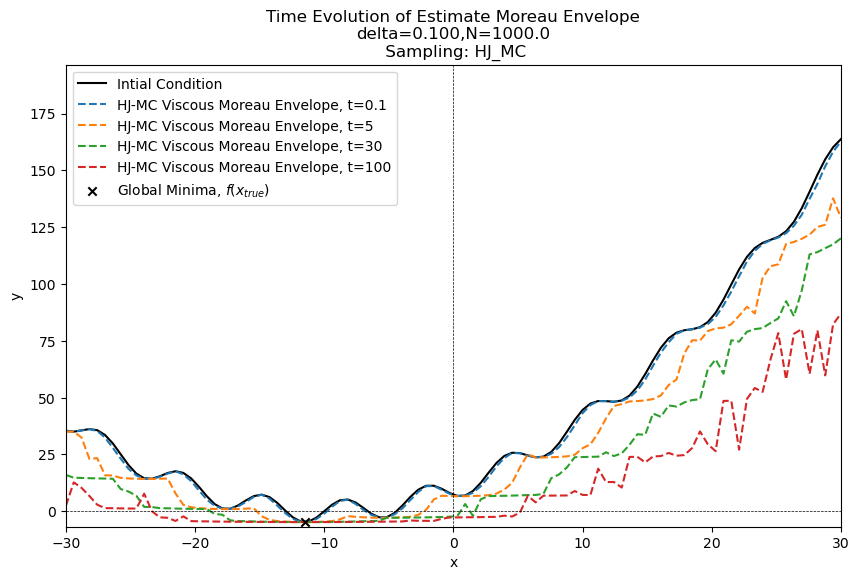

In [2]:
visualizer.plot_time_evolution()

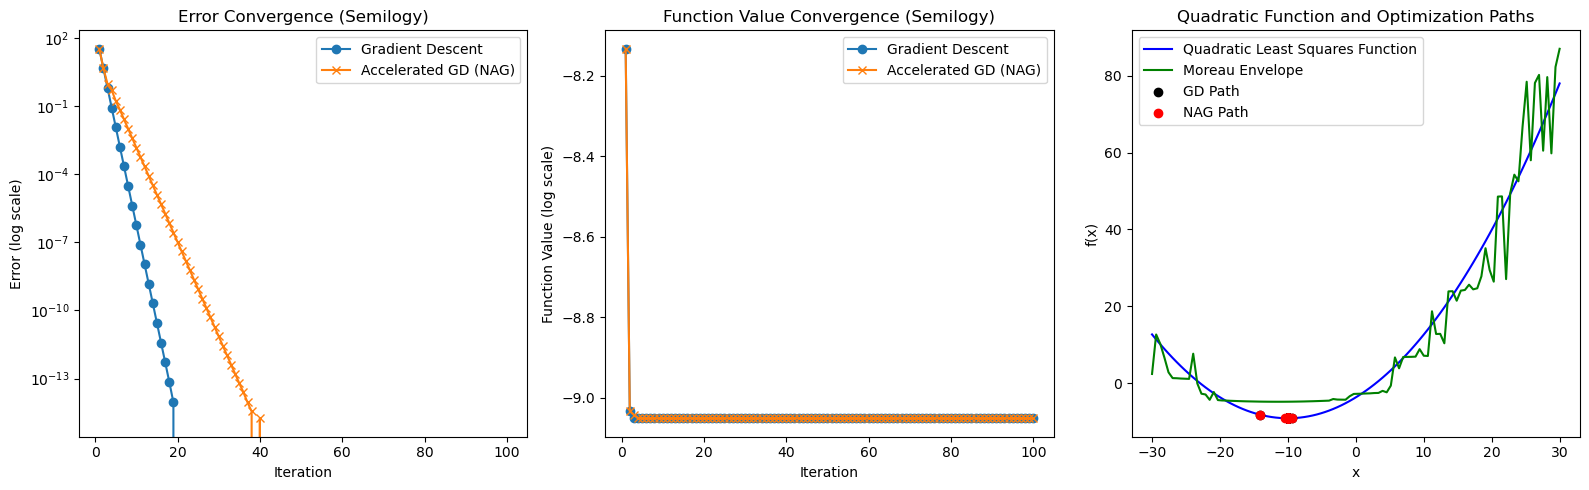

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class QuadraticOptimization:
    def __init__(self, beta, alpha, max_iterations):
        # Conditions from Visualizer
        coeffs = visualizer.fit_quadratic_to_moreau_envelope()
        self.a, self.b, self.c = coeffs
        x_0 = visualizer.x_0_input.value
        self.T  = visualizer.fixed_T_input.value
        self.x_vals = visualizer.x_values
        self.u_vals = visualizer.u_values

        # Adjustable parameters
        self.alpha = alpha
        self.max_iterations = max_iterations
        self.beta = beta

        # Variables for GD and Accelerated GD
        self.k = 0  # iteration counter
        self.x_k = x_0  # for gradient descent
        self.acc_x_k = x_0  # for accelerated gradient descent
        self.acc_x_k_minus_1 = x_0  # previous value for NAG

        # Lists to store function values and errors
        self.gd_errors = []
        self.nag_errors = []
        self.gd_values = []
        self.nag_values = []
        self.gd_points = []  # x values for gradient descent path
        self.nag_points = []  # x values for NAG path
        self.gk_hist = [(self.x_k,self.gradient(self.x_k))]

    def quadratic_function(self, x):
        """Quadratic function f(x) = ax^2 + bx + c."""
        return self.a * x ** 2 + self.b * x + self.c

    def gradient(self, x):
        """Gradient of the quadratic function: f'(x) = 2ax + b."""
        return 2 * self.a * x + self.b

    def gradient_descent(self, x):
        """Performs one step of gradient descent."""
        grad = self.gradient(x)
        return x - self.alpha * self.T * grad

    def run_optimization(self):
        for _ in range(self.max_iterations):
            # Perform standard Gradient Descent
            x_k_plus_1 = self.gradient_descent(self.x_k)
            self.gd_points.append(x_k_plus_1)

            # Store function value and error for GD
            gd_value = self.quadratic_function(x_k_plus_1)
            self.gd_values.append(gd_value)
            self.gd_errors.append(np.abs(x_k_plus_1 - self.x_k))
            
            # Update x_k for next iteration
            self.x_k = x_k_plus_1

            # Perform Accelerated Gradient Descent (NAG)
            if self.k > 1:
                y_k = self.acc_x_k + self.beta * (self.acc_x_k - self.acc_x_k_minus_1)
                acc_x_k_plus_1 = self.gradient_descent(y_k)
            else:
                acc_x_k_plus_1 = x_k_plus_1

            self.nag_points.append(acc_x_k_plus_1)

            # Store function value and error for NAG
            nag_value = self.quadratic_function(acc_x_k_plus_1)
            self.nag_values.append(nag_value)
            self.nag_errors.append(np.abs(acc_x_k_plus_1 - self.acc_x_k))

            # Update accelerated variables for next iteration
            self.acc_x_k_minus_1 = self.acc_x_k
            self.acc_x_k = acc_x_k_plus_1

            # Update iteration counter
            self.gk_hist.append((self.x_k,self.gradient(self.x_k)))
            self.k += 1

    def plot_results(self):
        """Plot error convergence, function value, and the quadratic function."""
        iterations = np.arange(1, self.max_iterations + 1)

        # Plot error convergence using semilogy
        plt.figure(figsize=(16, 5))

        plt.subplot(1, 3, 1)
        plt.semilogy(iterations, self.gd_errors, label='Gradient Descent', marker='o')
        plt.semilogy(iterations, self.nag_errors, label='Accelerated GD (NAG)', marker='x')
        plt.title('Error Convergence (Semilogy)')
        plt.xlabel('Iteration')
        plt.ylabel('Error (log scale)')
        plt.legend()

        # Plot function value using semilogy
        plt.subplot(1, 3, 2)
        plt.plot(iterations, self.gd_values, label='Gradient Descent', marker='o')
        plt.plot(iterations, self.nag_values, label='Accelerated GD (NAG)', marker='x')
        plt.title('Function Value Convergence (Semilogy)')
        plt.xlabel('Iteration')
        plt.ylabel('Function Value (log scale)')
        plt.legend()

        # Plot the quadratic function and the optimization points
        y_vals = self.quadratic_function(self.x_vals)

        plt.subplot(1, 3, 3)
        plt.plot(self.x_vals, y_vals, label='Quadratic Least Squares Function', color='blue')
        plt.plot(self.x_vals, self.u_vals, label='Moreau Envelope', color='green')
        plt.scatter(self.gd_points, [self.quadratic_function(x) for x in self.gd_points], color='black', label='GD Path', zorder=5)
        plt.scatter(self.nag_points, [self.quadratic_function(x) for x in self.nag_points], color='red', label='NAG Path', zorder=5)
        plt.title('Quadratic Function and Optimization Paths')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.legend()

        plt.tight_layout()
        plt.show()


# Example usage with a quadratic function f(x) = 2x^2 - 3x + 1
if __name__ == "__main__":
    alpha = 0.11
    beta = 0.5
    max_iterations = 100

    optimizer = QuadraticOptimization(beta, alpha, max_iterations)
    optimizer.run_optimization()
    optimizer.plot_results()
